In [3]:
import tensorflow as tf
import tensorflow.keras.layers as tfl
%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory

BATCH_SIZE = 32
IMG_SIZE = (224, 224)
directory = "drive/MyDrive/data_apr_24"
train_dataset = image_dataset_from_directory(directory,
                                             validation_split= 0.2,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             subset = "training",
                                             seed=42)

validation_dataset = image_dataset_from_directory(directory,
                                              validation_split= 0.2,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             subset = "validation",
                                             seed=42)



Found 688 files belonging to 2 classes.
Using 551 files for training.
Found 688 files belonging to 2 classes.
Using 137 files for validation.


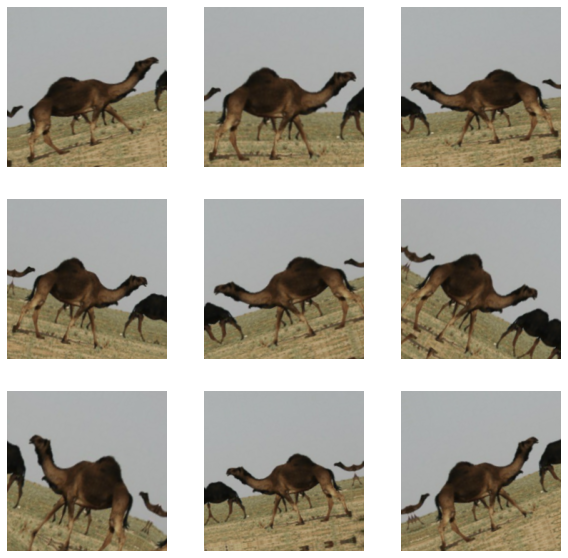

In [4]:
data_augmentation = tf.keras.Sequential([
        layers.experimental.preprocessing.Normalization(),
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(factor=0.02),
        layers.experimental.preprocessing.RandomZoom(height_factor=0.2, width_factor=0.2),
        layers.experimental.preprocessing.RandomRotation(0.1)
  ])

for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')



In [ ]:
DROPOUT = 0.5
fc_layers = [  226, 106, 50]
input_shape = IMG_SIZE + (3,)
  
  
base_model = tf.keras.applications.resnet.ResNet152(input_shape = input_shape, include_top = False)

# Freeze the base model by making it non trainable
base_model.trainable = False
# un-freeze the BatchNorm layers
for layer in base_model.layers:
    if "BatchNormalization" in layer.__class__.__name__:
        layer.trainable = True
# create the input layer (Same as the imageNetv2 input size)
inputs = tf.keras.Input(shape=input_shape) 

# apply data augmentation to the inputs
x = data_augmentation(inputs)
# data preprocessing using the same weights the model was trained on
# Already Done -> preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
x = preprocess_input = tf.keras.applications.resnet50.preprocess_input(x)

# set training to False to avoid keeping track of statistics in the batch norm layer
x = base_model(x) 

# Add the new Binary classification layers
# use global avg pooling to summarize the info in each channel
x = tfl.GlobalAveragePooling2D()(x) 
#include dropout with probability of 0.2 to avoid overfitting
x = tfl.Dropout(DROPOUT)(x)

for fc in fc_layers:
        x = tfl.Dense(fc, activation='relu')(x)
        x = tfl.Dropout(DROPOUT)(x)
# create a prediction layer with one neuron (as a classifier only needs one)
prediction_layer = tfl.Dense(1)


outputs = prediction_layer(x) 
model = tf.keras.Model(inputs, outputs)



In [ ]:
# Load saved Model
model = tf.keras.models.load_model('/content/drive/MyDrive/saved_model/my_model_92%')

In [ ]:
model.summary()
# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function= tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
base_learning_rate = 0.01
optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate)
# Use accuracy as evaluation metric
metrics=['accuracy']


model.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

In [ ]:
with tf.device('/device:GPU:0'): 
  intial_epochs = 20
  history = model.fit(train_dataset,
                           epochs=intial_epochs,
                           validation_data=validation_dataset)

Epoch 1/20
18/18 [==============================] - 45s 2s/step - loss: 0.0471 - accuracy: 0.9837 - val_loss: 1.2074 - val_accuracy: 0.8978
Epoch 2/20
18/18 [==============================] - 5s 221ms/step - loss: 0.0351 - accuracy: 0.9819 - val_loss: 1.4352 - val_accuracy: 0.8978
Epoch 3/20
18/18 [==============================] - 5s 225ms/step - loss: 0.0493 - accuracy: 0.9819 - val_loss: 1.5145 - val_accuracy: 0.8905
Epoch 4/20
 1/18 [>.............................] - ETA: 20s - loss: 0.0025 - accuracy: 1.0000

KeyboardInterrupt: ignored

In [ ]:
# Fine Tune the model
base_model.trainable = True
fine_tune_at = 450

print(len(base_model.layers))
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

model.summary()
optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10)

model.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

515
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 224, 224, 3)       7         
                                                                 
 tf.__operators__.getitem_4   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_4 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 global_average_pooling2d_4   (None, 2048)             

In [ ]:
with tf.device('/device:GPU:0'): 
  fine_tune_epochs = 100
  history_fine = model.fit(train_dataset,
                           epochs= intial_epochs + fine_tune_epochs,
                           initial_epoch=history.epoch[-1],
                           validation_data=validation_dataset)

Epoch 20/120
18/18 [==============================] - 23s 570ms/step - loss: 0.8119 - accuracy: 0.6025 - val_loss: 3114.5068 - val_accuracy: 0.5036
Epoch 21/120
18/18 [==============================] - 8s 414ms/step - loss: 0.6204 - accuracy: 0.6134 - val_loss: 57.0959 - val_accuracy: 0.5036
Epoch 22/120
18/18 [==============================] - 8s 411ms/step - loss: 0.5595 - accuracy: 0.6878 - val_loss: 1.3044 - val_accuracy: 0.3869
Epoch 23/120
18/18 [==============================] - 9s 421ms/step - loss: 0.5422 - accuracy: 0.6933 - val_loss: 0.9291 - val_accuracy: 0.5401
Epoch 24/120
18/18 [==============================] - 8s 419ms/step - loss: 0.5504 - accuracy: 0.7514 - val_loss: 85.9612 - val_accuracy: 0.5255
Epoch 25/120
18/18 [==============================] - 8s 418ms/step - loss: 0.4987 - accuracy: 0.7713 - val_loss: 11896.2148 - val_accuracy: 0.4964
Epoch 26/120
18/18 [==============================] - 8s 407ms/step - loss: 0.4471 - accuracy: 0.7423 - val_loss: 1011.7805 - 

KeyboardInterrupt: ignored

# Neuer Abschnitt

In [ ]:
# summarize history for accuracy
plt.plot(history_fine.history['accuracy'])
plt.plot(history_fine.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: ignored

In [ ]:
# save model
!mkdir -p saved_model
model.save('/content/drive/MyDrive/saved_model/my_mode_92%') 


NameError: ignored